In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install -c chembl chembl_structure_pipeline
import chembl_structure_pipeline
from chembl_structure_pipeline import standardizer

In [2]:
from IPython.display import clear_output

# https://www.dgl.ai/pages/start.html

# !pip install dgl
!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html # FOR CUDA VERSION
!pip install dgllife
!pip install rdkit-pypi
!pip install --pre deepchem
!pip install ipython-autotime
!pip install gputil
!pip install psutil
!pip install humanize

%load_ext autotime

clear = clear_output()

time: 1.61 ms (started: 2021-11-30 18:45:09 +00:00)


In [3]:
import os
from os import path
import statistics
import warnings
import random
import time 
import itertools
import psutil
import humanize
import GPUtil as GPU
import subprocess
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import tqdm
from tqdm import trange, tqdm_notebook, tnrange

import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv, SumPooling, MaxPooling
import dgl.function as fn
import dgllife
from dgllife import utils

# embedding
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.tensorboard import SummaryWriter


import sklearn
from sklearn.metrics import (auc, roc_curve, roc_auc_score, average_precision_score, 
                             accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, 
                             f1_score, PrecisionRecallDisplay)
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore", message="DGLGraph.__len__")

DGLBACKEND = 'pytorch'

clear

def get_cmd_output(command):
  return subprocess.check_output(command,
                        stderr=subprocess.STDOUT,
                        shell=True).decode('UTF-8')

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
time: 8.67 s (started: 2021-11-30 18:45:09 +00:00)


### Create Dataset

In [4]:
def create_dataset(df, name, bonds):
    print(f"Creating Dataset and Saving to {drive_path}/data/{name}.pkl")
    data = df.sample(frac=1)
    data = data.reset_index(drop=True)
    data['mol'] = data['smiles'].apply(lambda x: create_dgl_features(x, bonds))
    data.to_pickle(f"{drive_path}/data/{name}.pkl")
    return data

def featurize_atoms(mol):
  feats = []
  
  atom_features = utils.ConcatFeaturizer([
    utils.atom_type_one_hot,
    utils.atomic_number_one_hot,
    utils.atom_degree_one_hot,
    utils.atom_explicit_valence_one_hot,
    utils.atom_formal_charge_one_hot,
    utils.atom_num_radical_electrons_one_hot,
    utils.atom_hybridization_one_hot,
    utils.atom_is_aromatic_one_hot
  ])

  for atom in mol.GetAtoms():
    feats.append(atom_features(atom))
  return {'feats': torch.tensor(feats).float()}

def featurize_bonds(mol):
  feats = []
  
  bond_features = utils.ConcatFeaturizer([
    utils.bond_type_one_hot,
    utils.bond_is_conjugated_one_hot,
    utils.bond_is_in_ring_one_hot,
    utils.bond_stereo_one_hot,
    utils.bond_direction_one_hot,
  ])

  for bond in mol.GetBonds():
    feats.append(bond_features(bond))
    feats.append(bond_features(bond))
  return {'edge_feats': torch.tensor(feats).float()}

def create_dgl_features(smiles, bonds):
    mol = Chem.MolFromSmiles(smiles)
    mol = standardizer.standardize_mol(mol)
    
    if bonds:
        dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    edge_featurizer=featurize_bonds,
                                    canonical_atom_order=True)
    else:
      dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    canonical_atom_order=True)
    
    dgl_graph = dgl.add_self_loop(dgl_graph)
    
    return dgl_graph

def load_dataset(dataset, bonds=False, feat='graph', create_new=False):
  """
    dataset values: muv, tox21, dude-gpcr
    feat values: graph, ecfp
  """
  dataset_test_tasks = {
    'tox21': ['SR-HSE', 'SR-MMP', 'SR-p53'],
    'muv': ['MUV-832', 'MUV-846', 'MUV-852', 'MUV-858', 'MUV-859'],
    'dude-gpcr': ['adrb2', 'cxcr4']
  }

  dataset_original = dataset

  if bonds:
    dataset = dataset + "_with_bonds"

  if path.exists(f"{drive_path}/data/{dataset}_dgl.pkl") and not create_new:
    # Load Dataset
    print("Reading Pickle")
    if feat == 'graph':
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_dgl.pkl")
    else:
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_ecfp.pkl")
  else:
    # Create Dataset
    df = pd.read_csv(f"{drive_path}/data/raw/{dataset_original}.csv")
    if feat == 'graph':
      data = create_dataset(df, f"{dataset}_dgl", bonds)
    else:
      data = create_ecfp_dataset(df, f"{dataset}_ecfp")

  test_tasks = dataset_test_tasks.get(dataset_original)
  drop_cols = test_tasks.copy()
  drop_cols.extend(['mol_id', 'smiles', 'mol'])
  train_tasks = [x for x in list(data.columns) if x not in drop_cols]

  train_dfs = dict.fromkeys(train_tasks)
  for task in train_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']
      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)
      train_dfs[task] = df
  for key in train_dfs:
    print(key, len(train_dfs[key]))

  if feat == 'graph':
    feat_length = data.iloc[0].mol.ndata['feats'].shape[-1]
    print("Feature Length", feat_length)

    if with_bonds:
      feat_length = data.iloc[0].mol.edata['edge_feats'].shape[-1]
      print("Feature Length", feat_length)
    else:
      print("Edge Features: ", with_bonds)

  test_dfs = dict.fromkeys(test_tasks)

  for task in test_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']

      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)

      test_dfs[task] = df

  for key in test_dfs:
    print(key, len(test_dfs[key]))

  # return data, train_tasks, test_tasks
  return train_tasks, train_dfs, test_tasks, test_dfs

time: 154 ms (started: 2021-11-30 18:45:18 +00:00)


## Create Episode

In [5]:
def create_episode(n_support_pos, n_support_neg, n_query, data, test=False, train_balanced=True):
  """
    n_query = per class data points
    Xy = dataframe dataset in format [['y', 'mol']]
  """
  support = []
  query = []

  n_query_pos = n_query
  n_query_neg = n_query

  support_neg = data[data['y'] == 0].sample(n_support_neg)
  support_pos = data[data['y'] == 1].sample(n_support_pos)

  # organise support by class in array dimensions
  support.append(support_neg.to_numpy())
  support.append(support_pos.to_numpy())
  support = np.array(support, dtype=object)
  support_X = [rec[1] for sup_class in support for rec in sup_class]
  support_y = np.asarray([rec[0] for sup_class in support for rec in sup_class], dtype=np.float16).flatten()

  data = data.drop(support_neg.index)
  data = data.drop(support_pos.index)

  if len(data[data['y'] == 1]) < n_query:
    n_query_pos = len(data[data['y'] == 1])

  if test:
    # test uses all data remaining
    query_neg = data[data['y'] == 0].to_numpy()
    query_pos = data[data['y'] == 1].to_numpy()
  elif (not test) and train_balanced:
    # for balanced queries, same size as support
    query_neg = data[data['y'] == 0].sample(n_query_neg).to_numpy()
    query_pos = data[data['y'] == 1].sample(n_query_pos).to_numpy()
  elif (not test) and (not train_balanced):
    # print('test')
    query_neg = data[data['y'] == 0].sample(1).to_numpy()
    query_pos = data[data['y'] == 1].sample(1).to_numpy()

    query_rem = data.sample(n_query*2 - 2)
    query_neg_rem = query_rem[query_rem['y'] == 0].to_numpy()
    query_pos_rem = query_rem[query_rem['y'] == 1].to_numpy()

    query_neg = np.concatenate((query_neg, query_neg_rem))
    query_pos = np.concatenate((query_pos, query_pos_rem), axis=0)

  query_X = np.concatenate([query_neg[:, 1], query_pos[:, 1]])
  query_y = np.concatenate([query_neg[:, 0], query_pos[:, 0]])
  
  return support_X, support_y, query_X, query_y

time: 41.4 ms (started: 2021-11-30 18:45:18 +00:00)


## Graph Embedding

In [6]:
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels=128):
      super(GCN, self).__init__()
      self.conv1 = GraphConv(in_channels, 64)
      self.conv2 = GraphConv(64, 128)
      self.conv3 = GraphConv(128, 64)
      self.sum_pool = SumPooling()
      self.dense = nn.Linear(64, out_channels)

    def forward(self, graph, in_feat):
        h = self.conv1(graph, in_feat)
        h = F.relu(h)
        graph.ndata['h'] = h       
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))
      
        h = self.conv2(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        h = self.conv3(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        output = self.sum_pool(graph, graph.ndata['h'])
        output = torch.tanh(output)
        output = self.dense(output)
        output = torch.tanh(output)
        return output

time: 17.1 ms (started: 2021-11-30 18:45:18 +00:00)


## Relation Network

https://github.com/LSanghyeok/pytorch-learning-to-compare-relation-network-for-few-shot-learning


In [7]:
class RelationNet(nn.Module):
  def __init__(self):
    """
    Relation Network
    """
    super(RelationNet, self).__init__()
    self.stack = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU(),
        # nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        # nn.LeakyReLU(),
        nn.Linear(64, 8),
        nn.ReLU(),
        # nn.LeakyReLU(),
        nn.Linear(8, 1),
        # nn.Sigmoid() # FOR BCE LOSS
    )

  def forward(self, feature_concat):
    output = self.stack(feature_concat)
    return output

time: 5.72 ms (started: 2021-11-30 18:45:18 +00:00)


## LSTM

In [8]:
def cos(x, y):
  transpose_shape = tuple(list(range(len(y.shape)))[::-1])

  x = x.float()

  denom = (
      torch.sqrt(torch.sum(torch.square(x)) *
                     torch.sum(torch.square(y))) + torch.finfo(torch.float32).eps)

  return torch.matmul(x, torch.permute(y, transpose_shape)) / denom

class ResiLSTMEmbedding(nn.Module):
  def __init__(self, n_support, n_feat=128, max_depth=3):
    super(ResiLSTMEmbedding, self).__init__()

    self.max_depth = max_depth
    self.n_support = n_support
    self.n_feat = n_feat


    self.support_lstm = nn.LSTMCell(input_size=2*self.n_feat, hidden_size=self.n_feat)
    self.q_init = torch.nn.Parameter(torch.zeros((self.n_support, self.n_feat), dtype=torch.float, device="cuda"))
    self.support_states_init_h = torch.nn.Parameter(torch.zeros(self.n_support, self.n_feat))
    self.support_states_init_c = torch.nn.Parameter(torch.zeros(self.n_support, self.n_feat))
  
    self.query_lstm = nn.LSTMCell(input_size=2*self.n_feat, hidden_size=self.n_feat)

    if torch.cuda.is_available():
      self.support_lstm = self.support_lstm.cuda()
      self.query_lstm = self.query_lstm.cuda()
      self.q_init = self.q_init.cuda()
      # self.p_init = self.p_init.cuda()
  
  def forward(self, x_support, x_query):
    self.p_init = torch.zeros((len(x_query), self.n_feat)).to(device)
    self.query_states_init_h = torch.zeros(len(x_query), self.n_feat).to(device)
    self.query_states_init_c = torch.zeros(len(x_query), self.n_feat).to(device)

    z_support = x_support
    q = self.q_init
    p = self.p_init
    support_states_h = self.support_states_init_h
    support_states_c = self.support_states_init_c
    query_states_h = self.query_states_init_h
    query_states_c = self.query_states_init_c

    for i in range(self.max_depth):
      sup_e = cos(z_support + q, x_support)
      sup_a = torch.nn.functional.softmax(sup_e, dim=-1)
      sup_r = torch.matmul(sup_a, x_support).float()

      query_e = cos(x_query + p, z_support)
      query_a = torch.nn.functional.softmax(query_e, dim=-1)
      query_r = torch.matmul(query_a, z_support).float()

      sup_qr = torch.cat((q, sup_r), 1)
      support_hidden, support_out = self.support_lstm(sup_qr, (support_states_h, support_states_c))
      q = support_hidden

      query_pr = torch.cat((p, query_r), 1)
      query_hidden, query_out = self.query_lstm(query_pr, (query_states_h, query_states_c))
      p = query_hidden

      z_support = sup_r

    return x_support + q, x_query + p

time: 60.5 ms (started: 2021-11-30 18:45:18 +00:00)


## Training Loop

In [9]:
def train(train_tasks, train_dfs, balanced_queries, k_pos, k_neg, n_query, episodes, lr):
  
  writer = SummaryWriter()
  start_time = time.time()

  n_way = 2

  node_feat_size = 177
  embedding_size = 128
  
  encoder = GCN(node_feat_size, embedding_size)
  resi_lstm = ResiLSTMEmbedding(k_pos+k_neg)
  relation_net = RelationNet()
  loss_fn = nn.BCEWithLogitsLoss()

  if torch.cuda.is_available(): 
    encoder = encoder.cuda()
    resi_lstm = resi_lstm.cuda()
    relation_net = relation_net.cuda()
    loss_fn = loss_fn.cuda()

  encoder.train()
  resi_lstm.train()
  relation_net.train()

  encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = lr)
  lstm_optimizer = torch.optim.Adam(resi_lstm.parameters(), lr = lr)
  rn_optimizer = torch.optim.Adam(relation_net.parameters(), lr = lr)
  
  encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, patience=300, verbose=False)
  lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(lstm_optimizer, patience=300, verbose=False)
  rn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(rn_optimizer, patience=300, verbose=False)

  episode_num = 1
  early_stop = False
  losses = []

  running_loss = 0.0
  running_acc = 0.0
  running_roc = 0.0
  running_prc = 0.0

  pbar = trange(episodes, desc=f"Training")
  for episode in pbar:
    episode_loss = 0.0

    # RANDOMISE ORDER OF TASKS PER EPISODE
    shuffled_train_tasks = random.sample(train_tasks, len(train_tasks))

    # LOOP OVER TASKS
    for task in shuffled_train_tasks:
      # CREATE EPISODE FOR TASK
      X = train_dfs[task]
      X_support, y_support, X_query, y_query = create_episode(k_pos, k_neg, n_query, X, False, balanced_queries)

      # TOTAL NUMBER OF QUERIES
      total_query = int((y_query == 0).sum() + (y_query == 1).sum())

      # ONE HOT QUERY TARGETS
      # query_targets = torch.from_numpy(y_query.astype('int'))
      # targets = F.one_hot(query_targets, num_classes=2)

      query_targets = torch.from_numpy(y_query.astype('int'))
      one_hot = torch.zeros(total_query, n_way)
      one_hot[torch.arange(total_query), query_targets] = 1
      one_hot = Variable(one_hot)

      if torch.cuda.is_available(): 
        one_hot=one_hot.cuda()

      n_support = k_pos + k_neg
      X = X_support + list(X_query)

      # CREATE EMBEDDINGS
      dataloader = GraphDataLoader(X, batch_size=(n_support + total_query), shuffle=False, pin_memory=True)
      for graph in dataloader:
        graph = graph.to(device)
        
        if with_bonds:
          embeddings = encoder.forward(graph, (graph.ndata['feats'].float(), graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
        else:
          embeddings = encoder.forward(graph, graph.ndata['feats'].float()) # FOR NODES ONLY

      
      # LSTM EMBEDDINGS
      emb_support = embeddings[:n_support]
      emb_query = embeddings[n_support:]
      emb_support, emb_query = resi_lstm(emb_support, emb_query)

      # FEATURE CONCAT
      neg_emb_support = emb_support[:k_neg].sum(0).unsqueeze(0)
      pos_emb_support = emb_support[k_neg:].sum(0).unsqueeze(0)

      emb_support = torch.cat((neg_emb_support, pos_emb_support), 0)
      support_emb = emb_support.repeat(total_query, 1, 1)
      query_emb = embeddings[n_support:].unsqueeze(0).repeat(n_way, 1, 1).transpose(0, 1)
      feature_concat = torch.cat((support_emb, query_emb), 2)

      # RELATION NET
      rn_score = relation_net.forward(feature_concat).reshape(total_query, n_way)

      loss = loss_fn(rn_score, one_hot)

      encoder.zero_grad()
      resi_lstm.zero_grad()
      relation_net.zero_grad()

      loss.backward()
      
      encoder_optimizer.step()
      lstm_optimizer.step()
      rn_optimizer.step()

      # PREDICTION
      # NEED TO ADD SIGMOID HERE!!!!!!!!!!!!!!!!
      preds = rn_score.max(1)[1]

      preds = preds.detach().cpu()

      roc = roc_auc_score(query_targets, preds)
      prc = average_precision_score(query_targets, preds)
      acc = accuracy_score(query_targets, preds)
      
      episode_loss += loss.item()
      running_loss += loss.item()
      running_acc += acc
      running_roc += roc
      running_prc += prc

    pbar.set_description(f"Episode {episode_num} - Loss {loss.item():.6f} - Acc {acc:.4f} - LR {encoder_optimizer.param_groups[0]['lr']}")
    pbar.refresh()

    losses.append(episode_loss / len(train_tasks))
    writer.add_scalar('Loss/train', episode_loss / len(train_tasks), episode_num)

    if encoder_optimizer.param_groups[0]['lr'] < 0.000001:
      break # EARLY STOP
    elif episode_num < episodes:
      episode_num += 1

    encoder_scheduler.step(loss)
    lstm_scheduler.step(loss)

  epoch_loss = running_loss / (episode_num*len(train_tasks))
  epoch_acc = running_acc / (episode_num*len(train_tasks))
  epoch_roc = running_roc / (episode_num*len(train_tasks))
  epoch_prc = running_prc / (episode_num*len(train_tasks))

  print(f'Loss: {epoch_loss:.5f} Acc: {epoch_acc:.4f} ROC: {epoch_roc:.4f} PRC: {epoch_prc:.4f}')

  end_time = time.time()
  train_info = {
      "losses": losses,
      "duration": str(timedelta(seconds=(end_time - start_time))),
      "episodes": episode_num,
      "train_roc": epoch_roc,
      "train_prc": epoch_prc
  }

  return encoder, resi_lstm, relation_net, train_info

time: 218 ms (started: 2021-11-30 18:45:18 +00:00)


## Testing Loop

In [10]:
def test(encoder, lstm, relation_net, test_tasks, test_dfs, k_pos, k_neg, rounds):
  
  encoder.eval()
  lstm.eval()
  relation_net.eval()

  n_way = 2

  test_info = {}

  with torch.no_grad():
    for task in test_tasks:

      Xy = test_dfs[task]

      running_loss = []
      running_acc = []
      running_roc = [0]
      running_prc = [0]

      running_preds = []
      running_targets = []
      running_actuals = []

      for round in trange(rounds):
        X_support, y_support, X_query, y_query = create_episode(k_pos, k_neg, n_query=0, data=Xy, test=True, train_balanced=False)
        
        # QUERIES
        total_query = int((y_query == 0).sum() + (y_query == 1).sum())
        query_targets = torch.from_numpy(y_query.astype('int'))
        one_hot = torch.zeros(total_query, n_way)
        one_hot[torch.arange(total_query), query_targets] = 1
        one_hot = Variable(one_hot)

        if torch.cuda.is_available(): 
          one_hot=one_hot.cuda()

        n_support = k_pos + k_neg
        X = X_support + list(X_query)

        # CREATE EMBEDDINGS
        dataloader = GraphDataLoader(X, batch_size=(n_support + total_query), shuffle=False, pin_memory=True)
        for graph in dataloader:
          graph = graph.to(device)
          
          if with_bonds:
            embeddings = encoder.forward(graph, (graph.ndata['feats'].float(), graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
          else:
            embeddings = encoder.forward(graph, graph.ndata['feats'].float()) # FOR NODES ONLY

        
        # LSTM EMBEDDINGS
        emb_support = embeddings[:n_support]
        emb_query = embeddings[n_support:]
        emb_support, emb_query = lstm(emb_support, emb_query)

        # FEATURE CONCAT
        neg_emb_support = emb_support[:k_neg].sum(0).unsqueeze(0)
        pos_emb_support = emb_support[k_neg:].sum(0).unsqueeze(0)

        emb_support = torch.cat((neg_emb_support, pos_emb_support), 0)
        support_emb = emb_support.repeat(total_query, 1, 1)
        query_emb = embeddings[n_support:].unsqueeze(0).repeat(n_way, 1, 1).transpose(0, 1)
        feature_concat = torch.cat((support_emb, query_emb), 2)

        # RELATION NET
        rn_score = relation_net.forward(feature_concat).reshape(total_query, n_way)
        rn_score = nn.Sigmoid()(rn_score) # FOR BCE LOSS 

        # EVALUATE
        # preds = rn_score.max(1)[1]
        _, y_hat_actual = rn_score.max(1)
        y_hat = rn_score[:, 1]

        y_hat = y_hat.squeeze().detach().cpu()
        roc = roc_auc_score(query_targets, y_hat)
        prc = average_precision_score(query_targets, y_hat)
        # acc = accuracy_score(targets, y_hat)

        running_preds.append(y_hat)
        running_actuals.append(y_hat_actual)
        running_targets.append(query_targets)

        # running_acc.append(acc)
        running_roc.append(roc)
        running_prc.append(prc)

      median_index = running_roc.index(statistics.median(running_roc))
      if median_index == rounds:
        median_index = median_index - 1
      chart_preds = running_preds[median_index]
      chart_actuals = running_actuals[median_index].detach().cpu()
      chart_targets = running_targets[median_index]

      c_auc = roc_auc_score(chart_targets, chart_preds)
      c_fpr, c_tpr, _ = roc_curve(chart_targets, chart_preds)
      plt.plot(c_fpr, c_tpr, marker='.', label = 'AUC = %0.2f' % c_auc)
      plt.plot([0, 1], [0, 1],'r--', label='No Skill')
      # plt.plot([0, 0, 1], [0, 1, 1], 'g--', label='Perfect Classifier')
      plt.title('Receiver Operating Characteristic')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend(loc = 'best')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/roc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      # prc_graph = PrecisionRecallDisplay.from_predictions(chart_targets, chart_preds)
      c_precision, c_recall, _ = precision_recall_curve(chart_targets, chart_preds)
      plt.title('Precision Recall Curve')
      # plt.plot([0, 1], [0, 0], 'r--', label='No Skill')
      no_skill = len(chart_targets[chart_targets==1]) / len(chart_targets)
      plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
      # plt.plot([0, 1, 1], [1, 1, 0], 'g--', label='Perfect Classifier')
      plt.plot(c_recall, c_precision, marker='.', label = 'AUC = %0.2f' % auc(c_recall, c_precision))
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.legend(loc = 'best')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/prc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      cm = ConfusionMatrixDisplay.from_predictions(chart_targets, chart_actuals)
      plt.title('Confusion Matrix')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/cm_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      running_roc.pop(0) # remove the added 0
      running_prc.pop(0) # remove the added 0 
      # round_acc = f"{statistics.mean(running_acc):.3f} \u00B1 {statistics.stdev(running_acc):.3f}"
      round_roc = f"{statistics.mean(running_roc):.3f} \u00B1 {statistics.stdev(running_roc):.3f}"
      round_prc = f"{statistics.mean(running_prc):.3f} \u00B1 {statistics.stdev(running_prc):.3f}"

      test_info[task] = {
          # "acc": round_acc,
          "roc": round_roc,
          "prc": round_prc,
          "roc_values": running_roc,
          "prc_values": running_prc
      }

      print(f'Test {task}')
      # print(f"Acc: {round_acc}")
      print(f"ROC: {round_roc}")
      print(f"PRC: {round_prc}")

    return query_targets, y_hat, test_info

time: 191 ms (started: 2021-11-30 18:45:19 +00:00)


## Initiate Training and Testing

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 7min 16s (started: 2021-11-30 18:45:19 +00:00)


In [12]:
# PATHS
drive_path = "/content/drive/MyDrive/Colab Notebooks/MSC_21"
method_dir = "RelationNets"
log_path = f"{drive_path}/{method_dir}/logs/"

# PARAMETERS
dataset = 'dude-gpcr'
with_bonds = False 
k_shot = 10
test_rounds = 20
n_query = 64 # per class
episodes = 10000
lr = 0.0001
balanced_queries = True

time: 8.81 ms (started: 2021-11-30 18:52:35 +00:00)


In [13]:
#FOR DETERMINISTIC REPRODUCABILITY
randomseed = 12
torch.manual_seed(randomseed) 
np.random.seed(randomseed)
random.seed(randomseed)
torch.cuda.manual_seed(randomseed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.is_available()
torch.backends.cudnn.benchmark = False # selects fastest conv algo
torch.backends.cudnn.deterministic = True

# LOAD DATASET
train_tasks, train_dfs, test_tasks, test_dfs = load_dataset(dataset, bonds=with_bonds, feat='graph', create_new=False)

Reading Pickle
aa2ar 32032
drd3 34530
adrb1 16097
Feature Length 177
Edge Features:  False
adrb2 15231
cxcr4 3446
time: 53.4 s (started: 2021-11-30 18:52:35 +00:00)



RUNNING 10+/10-


Episode 2299 - Loss 0.693147 - Acc 0.5000 - LR 1.0000000000000002e-07:  23%|██▎       | 2298/10000 [04:38<15:32,  8.26it/s]


Loss: 0.69461 Acc: 0.5000 ROC: 0.5000 PRC: 0.5000


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Test adrb2
ROC: 0.500 ± 0.000
PRC: 0.015 ± 0.000


100%|██████████| 20/20 [00:02<00:00,  6.76it/s]


Test cxcr4
ROC: 0.500 ± 0.000
PRC: 0.009 ± 0.000


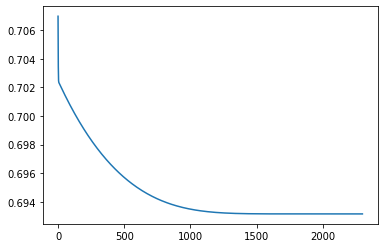

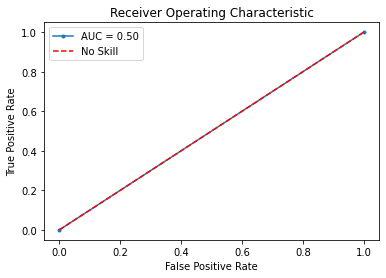

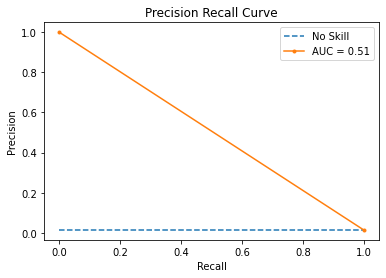

<Figure size 432x288 with 0 Axes>

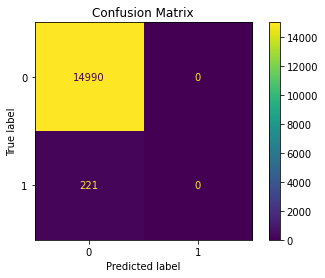

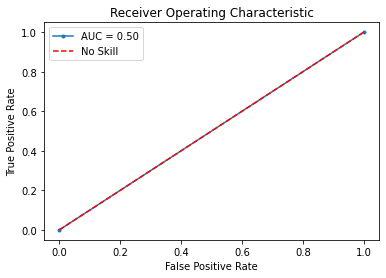

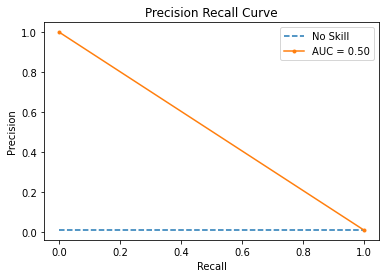

<Figure size 432x288 with 0 Axes>

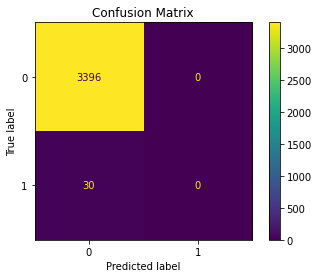

<Figure size 432x288 with 0 Axes>

time: 5min 13s (started: 2021-11-30 18:53:28 +00:00)


In [14]:
combinations = [
    [10, 10],
    # [5, 10], 
    # [1, 10], 
    # [1, 5], 
    # [1, 1]
]

cols = [
  'DATE', 'CPU', 'CPU COUNT',	'GPU', 'GPU RAM',	'RAM',	'CUDA',	
  'REF', 'DATASET', 'ARCHITECTURE',	
  'SPLIT',	'TARGET',	'ACCURACY',	'ROC',	'PRC',
  'ROC_VALUES', 'PRC_VALUES',
  'TRAIN ROC',	'TRAIN PRC',	'EPISODES',	'TRAINING TIME'
]

load_from_saved = False

for comb in combinations:
  n_pos = comb[0]
  n_neg = comb[1]
  results = pd.DataFrame(columns=cols)
  print(f"\nRUNNING {n_pos}+/{n_neg}-")

  if load_from_saved:
    encoder = GCN(177, 128)
    lstm = ResiLSTMEmbedding(n_pos+n_neg)
    relation_net = RelationNet()
    encoder.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}.pt"))
    lstm.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_lstm_pos{n_pos}_neg{n_neg}.pt"))
    relation_net.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_rn_pos{n_pos}_neg{n_neg}.pt"))
    encoder.to(device)
    lstm.to(device)
    relation_net.to(device)
  else:
    encoder, lstm, relation_net, train_info = train(train_tasks, train_dfs, balanced_queries, n_pos, n_neg, n_query, episodes, lr)

    if with_bonds:
      torch.save(encoder.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}_bonds.pt")
      torch.save(lstm.state_dict(), f"{drive_path}/{method_dir}/{dataset}_lstm_pos{n_pos}_neg{n_neg}_bonds.pt")
      torch.save(relation_net.state_dict(), f"{drive_path}/{method_dir}/{dataset}_rn_pos{n_pos}_neg{n_neg}_bonds.pt")
    else:
      torch.save(encoder.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}.pt")
      torch.save(lstm.state_dict(), f"{drive_path}/{method_dir}/{dataset}_lstm_pos{n_pos}_neg{n_neg}.pt")
      torch.save(relation_net.state_dict(), f"{drive_path}/{method_dir}/{dataset}_rn_pos{n_pos}_neg{n_neg}.pt")
    
    loss_plot = plt.plot(train_info['losses'])[0]
    loss_plot.figure.savefig(f"{drive_path}/{method_dir}/loss_plots/{dataset}_pos{n_pos}_neg{n_neg}.png")
    plt.figure().clear()

  targets, preds, test_info = test(encoder, lstm, relation_net, test_tasks, test_dfs, n_pos, n_neg, test_rounds)

  dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  cpu = get_cmd_output('cat /proc/cpuinfo | grep -E "model name"')
  cpu = cpu.split('\n')[0].split('\t: ')[-1]
  cpu_count = psutil.cpu_count()
  cuda_version = get_cmd_output('nvcc --version | grep -E "Build"')
  gpu = get_cmd_output("nvidia-smi -L")
  general_ram_gb = humanize.naturalsize(psutil.virtual_memory().available)
  gpu_ram_total_mb = GPU.getGPUs()[0].memoryTotal

  for target in test_info:
    if load_from_saved:
      rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                          dataset, {method_dir}, f"{n_pos}+/{n_neg}-", target, 0, test_info[target]['roc'], test_info[target]['prc'], 
                          test_info[target]['roc_values'], test_info[target]['prc_values'],
                          99, 99, 99, 102]], columns=cols)
  
      results = pd.concat([results, rec])
    else:
      rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                          dataset, {method_dir}, f"{n_pos}+/{n_neg}-", target, 0, test_info[target]['roc'], test_info[target]['prc'], 
                          test_info[target]['roc_values'], test_info[target]['prc_values'],
                          train_info["train_roc"], train_info["train_prc"], train_info["episodes"], train_info["duration"]
            ]], columns=cols)
  
      results = pd.concat([results, rec])

  if load_from_saved:
    results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}_from_saved.csv", index=False)
  else:
    results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}.csv", index=False)